In [1]:
import sys
import os
import glob
import copy
from matplotlib import pyplot as plt
from pprint import pprint
sys.path.append('../..')

from model import processing

In [7]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

def get_initial_state(price_data, params):
    tkn = list(price_data[0].keys())[0]
    assets = {
        'HDX': {'usd price': 0.05, 'weight': 0.10},
        'USD': {'usd price': 1, 'weight': 0.19},
        'DOT': {'usd price': 1, 'weight': 0.10},
        'ETH': {'usd price': 1, 'weight': 0.60},
        tkn: {'usd price': price_data[0][tkn], 'weight': 0.01},
    }

    lrna_price_usd = 22.22
    initial_omnipool_tvl = 50000000
    liquidity = {}
    lrna = {}

    for tkn, info in assets.items():
        liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
        lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

    initial_state = GlobalState(
        pools={
            'omnipool': OmnipoolState(
                tokens={
                    tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                },
                oracles={'fee_raise': 10},  # , 'fee_lower': 7200},
                lrna_fee=dynamicadd_lrna_fee(
                    minimum=params.lrna_fee_min,
                    amplification=params.lrna_fee_amplification,
                    raise_oracle_name='fee_raise',
                    decay=params.lrna_fee_decay,
                    fee_max=params.lrna_fee_max,
                ),
                asset_fee=dynamicadd_asset_fee(
                    minimum=params.asset_fee_min,
                    amplification=params.asset_fee_amplification,
                    raise_oracle_name='fee_raise',
                    decay=params.asset_fee_decay,
                    fee_max=params.asset_fee_max,
                ),
            )
        },
        agents = {
            'Arbitrageur': Agent(
                holdings={tkn: 1000000000 for tkn in assets},
                trade_strategy=omnipool_arbitrage(
                    pool_id='omnipool',
                    frequency=params.arb_frequency
                )
            )
        },
        evolve_function=historical_prices(price_data),
        external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    )
    return initial_state

In [8]:
# set up scenarios

def interpolate_hourly(tkn: str, hourly_prices: dict):
    price_data = []
    prices = list(hourly_prices.values())
    hours = list(hourly_prices.keys())
    last_price = prices[0]
    last_hour = 0
    for hour in hours[1:]:
        price = hourly_prices[hour]
        time_range = hour - last_hour
        price_range = price - last_price
        blocks_per_hour = 300
        price_data += [{tkn: last_price + price_range / blocks_per_hour / time_range * i} for i in range(blocks_per_hour * time_range)]
        last_price = price
        last_hour = hour
    return price_data

scenarios = {
    'ASTR dip': lambda: processing.import_binance_prices(["ASTR"], "January 3 2024", days=1)[3400 : 3900],
    'VDOT crash': lambda: interpolate_hourly('VDOT', {0: 9.40, 1: 5.72, 2: 5.42, 8: 6.10, 24: 6.24, 25: 6.92, 26: 8.63, 27: 8.95, 28: 9.03})
}

In [9]:
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, SelectionSlider
from IPython.display import display, HTML, clear_output
from io import BytesIO
import base64

current_scenario = 'ASTR dip'
price_data = scenarios[current_scenario]()

class Results:
    events: list = [],
    price_data: list = price_data,
    scenario = current_scenario
    def __init__(self):
        return None
    
    def set_scenario(self, scenario_name):
        self.scenario = scenario_name
        self.price_data = scenarios[scenario_name]()
    
    def run(self):
        start_state = get_initial_state(self.price_data, params)
        self.events = run.run(start_state, time_steps=len(self.price_data) - 1)
        return self.events
    
output = Results()

@interact(scenario_name = widgets.Dropdown(options=scenarios.keys(), description='Scenario'))
def set_scenario(scenario_name):
    output.set_scenario(scenario_name)
    plt.figure(figsize=(20, 5))
    plt.plot([list(block.values())[0] for block in output.price_data])

class Params():
    def __init__(
        self,
        lrna_fee_amplification,
        lrna_fee_decay,
        lrna_fee_min,
        lrna_fee_max,
        asset_fee_amplification,
        asset_fee_decay,
        asset_fee_min,
        asset_fee_max,
        arb_frequency
    ):
        self.lrna_fee_amplification = lrna_fee_amplification
        self.lrna_fee_decay = lrna_fee_decay
        self.lrna_fee_min = lrna_fee_min
        self.lrna_fee_max = lrna_fee_max
        self.asset_fee_amplification = asset_fee_amplification
        self.asset_fee_decay = asset_fee_decay
        self.asset_fee_min = asset_fee_min
        self.asset_fee_max = asset_fee_max
        self.arb_frequency = arb_frequency
        
    def __str__(self):
        return (
            f"LRNA fee amplification: {self.lrna_fee_amplification} \n"
            f"LRNA fee decay: {self.lrna_fee_decay} \n"
            f"LRNA fee min: {self.lrna_fee_min} \n"
            f"LRNA fee max: {self.lrna_fee_max} \n"
            f"asset fee amplification: {self.asset_fee_amplification} \n"
            f"asset fee decay: {self.asset_fee_decay} \n"
            f"asset fee min: {self.asset_fee_min} \n"
            f"asset fee max: {self.asset_fee_max} \n"
            f"arbitrage frequency: every {self.arb_frequency} blocks"
        )

interactive(children=(Dropdown(description='Scenario', options=('ASTR dip', 'VDOT crash'), value='ASTR dip'), …

In [10]:
#-------------------------------------------------------------
#                     set parameters here
#-------------------------------------------------------------

params = Params(
    lrna_fee_amplification=1.0,
    lrna_fee_decay=0.000005,
    lrna_fee_min=0.0005,
    lrna_fee_max=0.001,
    asset_fee_amplification=2.0,
    asset_fee_decay=0.00001,
    asset_fee_min=0.0025,
    asset_fee_max=0.05,
    arb_frequency=1
)

# defaults for reference (don't change)
default_params = Params(
    lrna_fee_amplification=1.0,
    lrna_fee_decay=0.000005,
    lrna_fee_min=0.0005,
    lrna_fee_max=0.001,
    asset_fee_amplification=2.0,
    asset_fee_decay=0.00001,
    asset_fee_min=0.0025,
    asset_fee_max=0.05,
    arb_frequency=1
)

Starting simulation...
Execution time: 0.328 seconds.


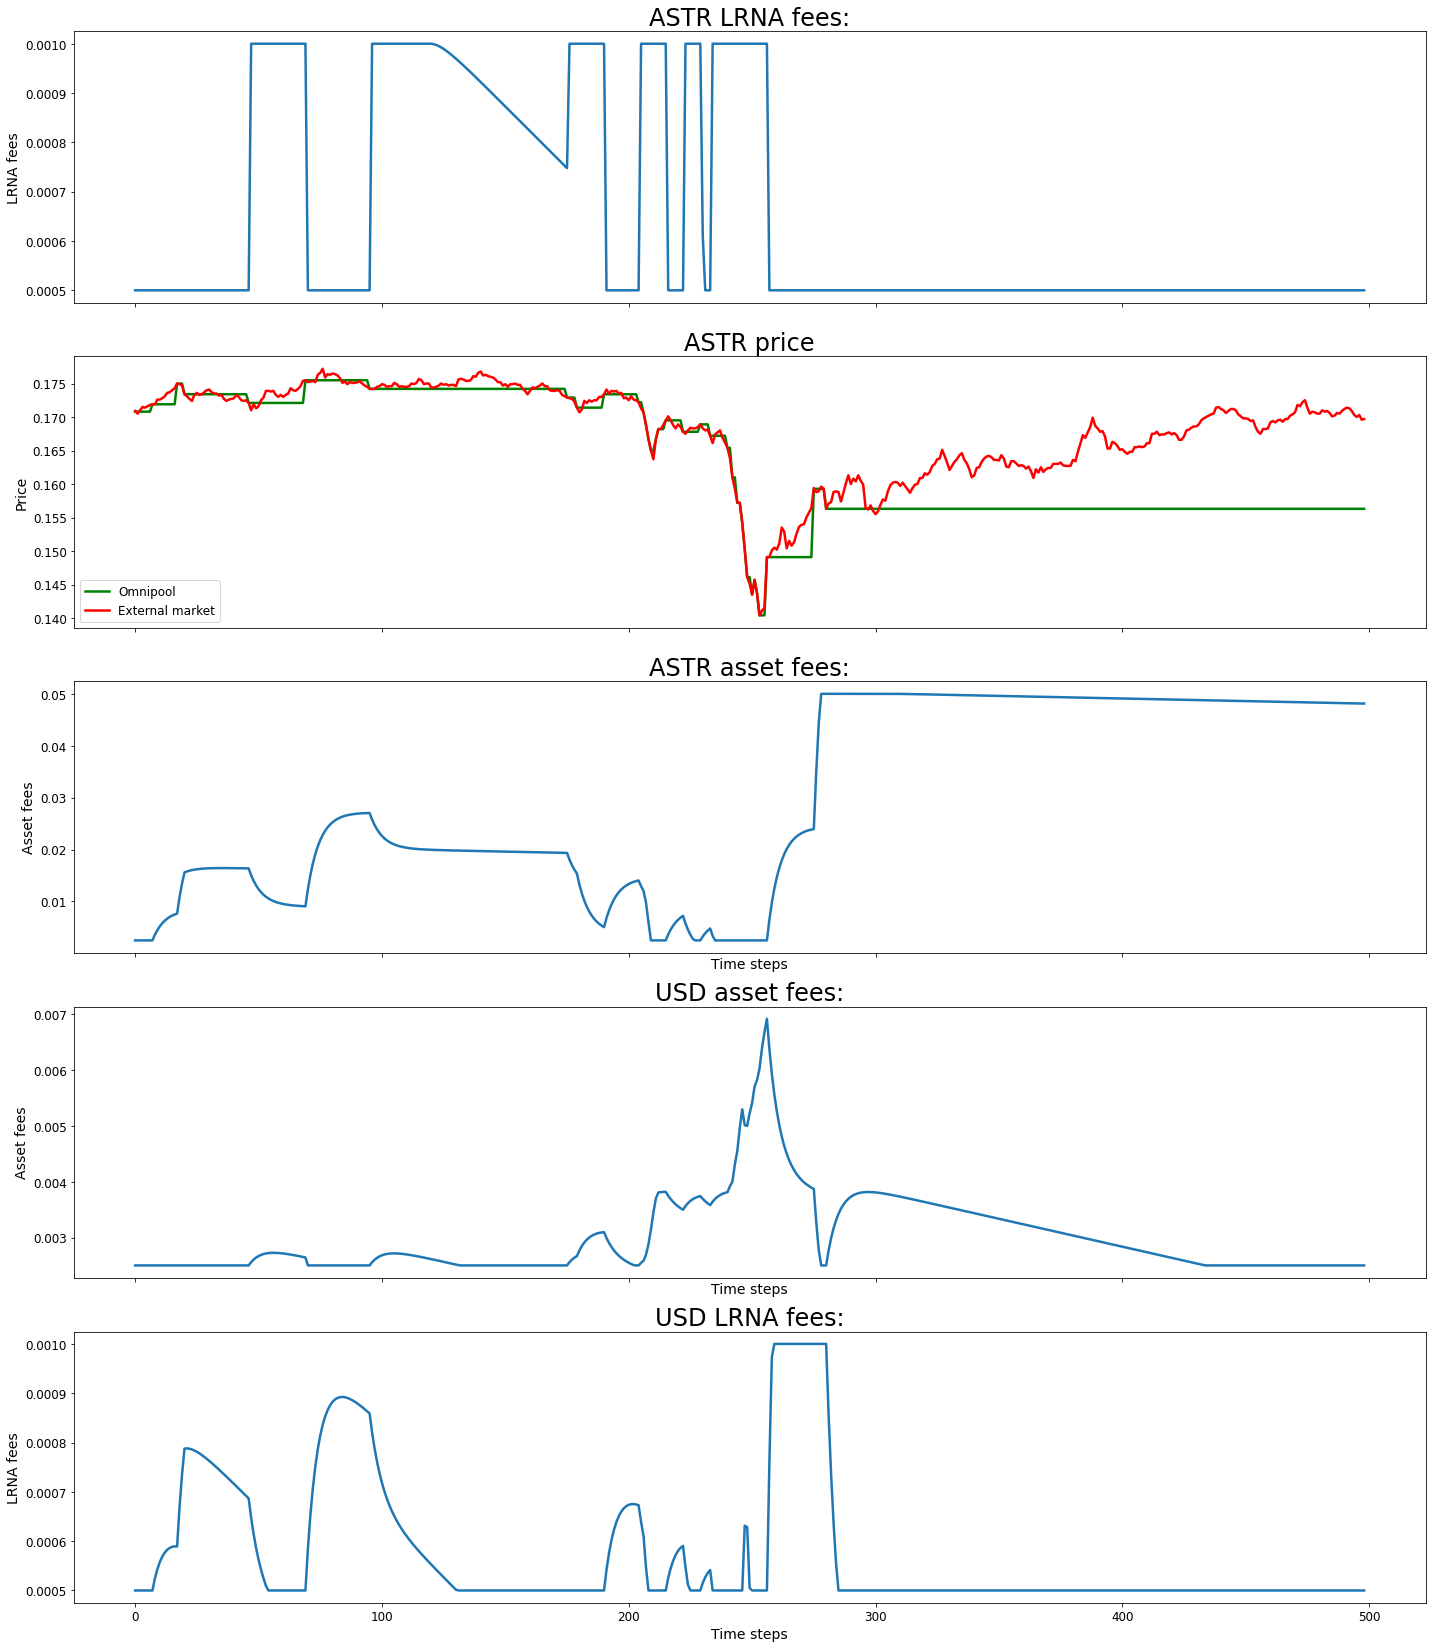

In [22]:
def create_aligned_plots(events, tkn):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20, 25), sharex=True)
    
    # Set an even larger font size for titles
    title_font_size = 24  # Increased from 16 to 24
    
    # Set line thickness
    line_width = 2.5  # Increased line thickness
    
    # LRNA fees graph
    ax1.plot([event.pools['omnipool'].last_lrna_fee[tkn] for event in events], linewidth=line_width)
    ax1.set_title(f'{tkn} LRNA fees:', fontsize=title_font_size)
    ax1.set_ylabel('LRNA fees')
    
    # Price graph
    ax2.plot([usd_price(event.pools['omnipool'], tkn) for event in events], color='green', label='Omnipool', linewidth=line_width)
    ax2.plot([event.external_market[tkn] for event in events], color='red', label='External market', linewidth=line_width)
    ax2.set_title(f'{tkn} price', fontsize=title_font_size)
    ax2.set_ylabel('Price')
    ax2.legend(fontsize=12)  # Increased legend font size
    
    # Asset fees graph
    ax3.plot([event.pools['omnipool'].last_fee[tkn] for event in events], linewidth=line_width)
    ax3.set_title(f'{tkn} asset fees:', fontsize=title_font_size)
    ax3.set_ylabel('Asset fees')
    ax3.set_xlabel('Time steps')
    
    ax4.plot([event.pools['omnipool'].last_fee['USD'] for event in output.events], linewidth=line_width)
    ax4.set_title(f'USD asset fees:', fontsize=title_font_size)
    ax4.set_ylabel('Asset fees')
    ax4.set_xlabel('Time steps')
    
    ax5.plot([event.pools['omnipool'].last_lrna_fee['USD'] for event in output.events], linewidth=line_width)
    ax5.set_title(f'USD LRNA fees:', fontsize=title_font_size)
    ax5.set_ylabel('LRNA fees')
    ax5.set_xlabel('Time steps')
    
    # Increase font size for axis labels and tick labels
    axis_label_font_size = 14
    tick_label_font_size = 12
    
    for ax in (ax1, ax2, ax3, ax4, ax5):
        ax.xaxis.label.set_fontsize(axis_label_font_size)
        ax.yaxis.label.set_fontsize(axis_label_font_size)
        ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
    
    # Adjust layout to accommodate larger titles
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig

events = output.run()
tkn = list(output.price_data[0].keys())[0]
fig = create_aligned_plots(events, tkn)
plt.show()

In [15]:
type(events[1])

model.amm.global_state.GlobalState